In [1]:
from __future__ import print_function
from fenics import *
from dolfin import *
from mshr import *
import numpy as np
import matplotlib.pyplot as plt
import pylab  
import random

In [2]:
parameters["form_compiler"]["cpp_optimize"] = True
ffc_options = {"optimize": True, \
               "eliminate_zeros": True, \
               "precompute_basis_const": True, \
               "precompute_ip_const": True}

(3971, 2)


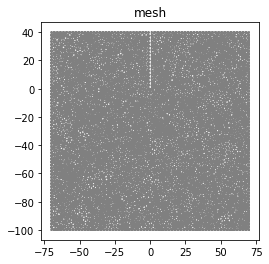

In [3]:
L = 0.5
R = 0.5
N = 50 # mesh density
domain = Rectangle(Point(-70.0,-100.0), Point(70.0, 40.0)) - Rectangle(Point(-1.0,0.0), Point(1.0, 40.95))
mesh = generate_mesh(domain, N)
plot ( mesh, title = 'mesh' )
mesh_points=mesh.coordinates()
print(mesh_points.shape)

In [4]:
Dphi = Constant(1.0)
E = 100000000
nu = 0.3
lmbda = Constant(E*nu/((1+nu)*(1-2*nu))) 
mu = Constant(E/2/(1+nu))

In [5]:
d = 1 # interpolation degree
Vue = VectorElement('CG', mesh.ufl_cell(), d) # displacement finite element
Vp1e = FiniteElement('CG', mesh.ufl_cell(), d) # concentration finite element
Vp2e = FiniteElement('CG', mesh.ufl_cell(), d) # concentration finite element
V = FunctionSpace(mesh, MixedElement([Vue, Vp1e, Vp2e]))

# Boundary conditions
def inner_b(x, on_boundary):
    return near(x[1], -0.0) and on_boundary
def inner_l(x, on_boundary):
    return near(x[0], -1.0) and on_boundary
def inner_r(x, on_boundary):
    return near(x[0], 1.0) and on_boundary
def bottom(x, on_boundary):
    return near(x[1], -100.0) and on_boundary
def left(x, on_boundary):
    return near(x[0], -70.0) and on_boundary
def right(x, on_boundary):
    return near(x[0], 70.0) and on_boundary
def top(x, on_boundary):
    return near(x[1], 40.0) and on_boundary
bc1 = DirichletBC(V.sub(1), Constant(0.), left)
bc2 = DirichletBC(V.sub(1), Constant(0.), right)
bc3 = DirichletBC(V.sub(1), Constant(0.), bottom)
bc4 = DirichletBC(V.sub(2), Constant(0.), left)
bc5 = DirichletBC(V.sub(2), Constant(0.), right)
bc6 = DirichletBC(V.sub(2), Constant(0.), bottom)
bc7 = DirichletBC(V.sub(0).sub(0), Constant(0.), left)
bc8 = DirichletBC(V.sub(0).sub(0), Constant(0.), right)
bc9 = DirichletBC(V.sub(0).sub(0), Constant(0.), bottom)
bc10 = DirichletBC(V.sub(0).sub(1), Constant(0.), left)
bc11 = DirichletBC(V.sub(0).sub(1), Constant(0.), right)
bc12 = DirichletBC(V.sub(0).sub(1), Constant(0.), bottom)

bc13 = DirichletBC(V.sub(1), Constant(1.), inner_b)

bcs = [bc1,bc2,bc3,bc7,bc8,bc9,bc10,bc11,bc12,bc13]

In [6]:
# Defining multiple Neumann boundary conditions 
mf = MeshFunction("size_t", mesh, 1)
mf.set_all(0) # initialize the function to zero
class inner_b(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1], 0.0) and on_boundary
inner_b = inner_b() # instantiate it
inner_b.mark(mf, 1)
ds = ds(subdomain_data = mf) 

In [7]:
U_ = TestFunction(V)
(u_, P1_, P2_) = split(U_)  
dU = TrialFunction(V)
(du, dP1, dP2) = split(dU) 
U = Function(V)
(u, P1, P2) = split(U)  # P1 = \rho_aR and P2 = \rho_wR

In [8]:
d = u.geometric_dimension()
I = Identity(d)             # Identity tensor

F = I + grad(u)             # Deformation gradient
C = F.T * F                # Elastic right Cauchy-Green tensor
Finv = inv(F)
k = 0.1            # Permeability of soil
phi = 0.9  # \phi_s
R = 8.32
T = 398
gamma_w = 1000

# Invariants of deformation tensors
Ic = tr(C)
J1 = det(F)

phi_a = 1-phi-P2/(J1*gamma_w)
phi_w = P2/(J1*gamma_w)
gamma_a = P1/(J1*phi_a)

F1 = phi* (mu * F - mu * Finv.T + lmbda*ln(J1) * Finv.T) - (1-phi)/phi_a *(P1*R*T* Finv.T) # S

F1 = (1/J1)*F.T * F1

J_a = k*R*T*phi_a*grad(gamma_a) # P_p1
J_w = k*R*T*phi_w*grad(gamma_a) # P_p2

#  Define time things.
dt = Constant(0.01)

P_init = Expression ( "0.0", degree = 0 )
P_old = project ( P_init, V.sub(1).collapse())

P_init2 = Expression ( "0.0", degree = 0 )
P_old2 = project ( P_init2, V.sub(1).collapse())

y_BC = Expression(("0.0", "0.0"),degree=0)
u = project(y_BC,V.sub(0).collapse())

f = Expression(("0.0", "0.0"),degree=0) #Constant((0,-10))
g_a = Expression(("100.0"),degree=0)

g_w = Expression(("200.0"),degree=0)

mech_form = inner(F1, grad(u_))*dx + inner(140*f,u_)*dx
p_form1 = 1*J1*inner(((J_a) + 6.5*f), grad(P1_))*dx + ( P1 - P_old )/dt * P1_ * dx #- J1*g_a*P1_*ds(1)
p_form2 = 1*J1*inner(((J_w) + 6.5*f), grad(P2_))*dx + ( P2 - P_old2 )/dt * P2_ * dx - J1*g_w*P2_*ds(1)

F = mech_form + p_form1 + p_form2 
J = derivative(F, U, dU)

In [9]:
problem = NonlinearVariationalProblem(F, U, bcs, J)
solver  = NonlinearVariationalSolver(problem)

prm = solver.parameters
prm['newton_solver']['absolute_tolerance'] = 1E-8
prm['newton_solver']['relative_tolerance'] = 1E-5
prm['newton_solver']['maximum_iterations'] = 25
prm['newton_solver']['relaxation_parameter'] = 1.0

In [10]:
m = []
Nincr = 50
t = np.linspace(0.5 ,100, Nincr+1)
# t = t[0:20]
U = Function(V)
for (i, dti) in enumerate(np.array(t)):
    print("Increment " + str(i+1))
    dt.assign(dti)
    print(dti)
    solver.solve()
    (u1, P11,P22) = U.split()
    P_old = P11.copy()


Increment 1
0.5
Increment 2
2.49
Increment 3
4.48
Increment 4
6.47
Increment 5
8.46
Increment 6
10.45
Increment 7
12.44
Increment 8
14.43
Increment 9
16.42
Increment 10
18.41
Increment 11
20.4
Increment 12
22.39
Increment 13
24.38
Increment 14
26.37
Increment 15
28.36
Increment 16
30.35
Increment 17
32.34
Increment 18
34.33
Increment 19
36.32
Increment 20
38.31
Increment 21
40.3
Increment 22
42.29
Increment 23
44.28
Increment 24
46.27
Increment 25
48.26
Increment 26
50.25
Increment 27
52.24
Increment 28
54.23
Increment 29
56.22
Increment 30
58.21
Increment 31
60.2
Increment 32
62.19
Increment 33
64.18
Increment 34
66.17
Increment 35
68.16
Increment 36
70.15
Increment 37
72.14
Increment 38
74.13
Increment 39
76.12
Increment 40
78.11
Increment 41
80.1
Increment 42
82.09
Increment 43
84.08
Increment 44
86.07
Increment 45
88.06
Increment 46
90.05
Increment 47
92.04
Increment 48
94.03
Increment 49
96.02
Increment 50
98.01
Increment 51
100.0


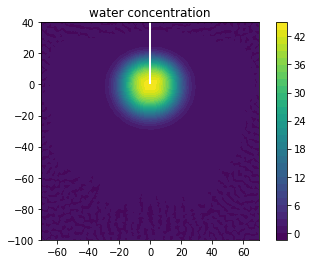

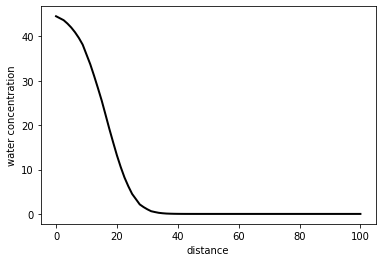

In [11]:
M=plot(P2, title= 'water concentration')
# plt.xlim((-40, 40))
# plt.ylim((-40, 40))
plt.colorbar(M)  
filename = 'Phidistribution.png'
plt.savefig ( filename )
plt.show()

tol = 0.001  # avoid hitting points outside the domain
yy = np.linspace(0.0 + tol, 100.0 - tol, 81)
points = [(0 , -yy_ ) for yy_ in yy]  # 2D points
# print(points)
u_line = np.array([P2(point) for point in points])
# print(np.max(u_line))
plt.plot(yy, u_line, 'k', linewidth=2)
plt.ylabel('water concentration')
plt.xlabel('distance')
plt.show()

np.savetxt('y.CSV',u_line)
np.savetxt('x.CSV',yy)

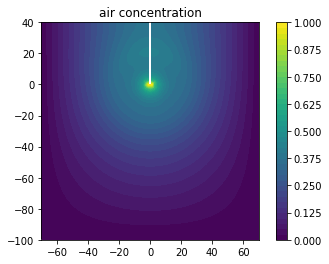

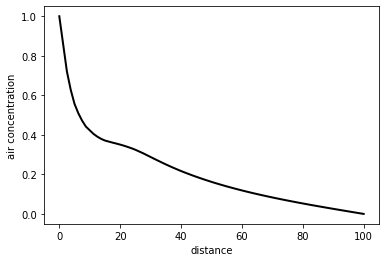

In [12]:
M=plot(P1, title= 'air concentration')
# plt.xlim((-40, 40))
# plt.ylim((-40, 40))
plt.colorbar(M)  
filename = 'Phidistribution.png'
plt.savefig ( filename )
plt.show()

tol = 0.001  # avoid hitting points outside the domain
yy = np.linspace(0.0 + tol, 100.0 - tol, 81)
points = [(0 , -yy_ ) for yy_ in yy]  # 2D points
# print(points)
u_line = np.array([P1(point) for point in points])
# print(np.max(u_line))
plt.plot(yy, u_line, 'k', linewidth=2)
plt.ylabel('air concentration')
plt.xlabel('distance')
plt.show()

np.savetxt('y.CSV',u_line)
np.savetxt('x.CSV',yy)

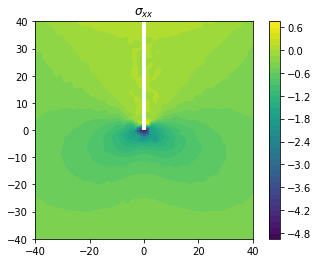

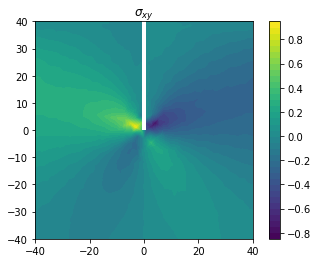

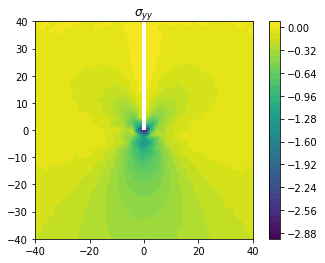

In [13]:
W = TensorFunctionSpace(mesh, "Lagrange", 2)
sigma_w = project(  (phi)* (mu * inv(Finv) - mu * Finv.T + lmbda*ln(det(inv(Finv))) * Finv.T) - (1-phi)/phi_a*(P1*R*T* Finv.T) , W)


M1 = plot(sigma_w[0,0]*0.001, title='$\sigma_{xx}$')
plt.xlim((-40.0, 40.0))
plt.ylim((-40.0, 40.0))
plt.colorbar(M1)
# plt.contour(M1)
# M1.set_clim(-800,5500)
filename = 'xx.png'
plt.savefig ( filename )
plt.show()


M2 = plot(sigma_w[1,0]*0.001 ,title='$\sigma_{xy}$')
plt.xlim((-40.0, 40.0))
plt.ylim((-40.0, 40.0))
plt.colorbar(M2)
# M2.set_clim(-1000,1000)
filename = 'xy.png'
plt.savefig ( filename )
plt.show()


M4 = plot(sigma_w[1,1]*0.001, title='$\sigma_{yy}$')
plt.xlim((-40.0, 40.0))
plt.ylim((-40.0, 40.0))
plt.colorbar(M4)
# M4.set_clim(-500,5000)
filename = 'yy.png'
plt.savefig ( filename )
plt.show()


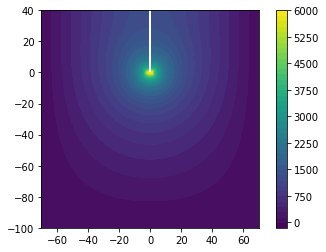

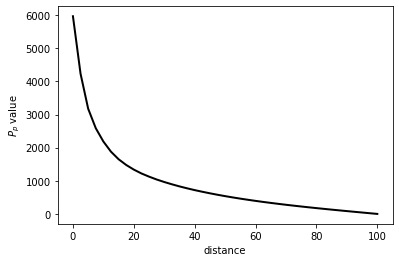

In [14]:
W = TensorFunctionSpace(mesh, "Lagrange", 2)

por_p = project(1/det(inv(Finv))*P1*R*T*((1-phi)/phi_a)*Identity(2) , W)

# (1-phi)/phi_a *(P1*R*T* Finv.T)

M5 = plot(por_p[1,1])
plt.colorbar(M5)
plt.show()

P0 = por_p[1,1]

tol = 0.001  # avoid hitting points outside the domain
yy = np.linspace(0.0 + tol, 100.0 - tol, 41)
points = [(0 , -yy_ ) for yy_ in yy]  # 2D points
u_line = np.array([P0(point) for point in points])
plt.plot(yy, u_line, 'k', linewidth=2)
plt.ylabel('$P_p$ value')
plt.xlabel('distance')
plt.show()

np.savetxt('yp.CSV',u_line)
np.savetxt('xp.CSV',yy)

por_p1 = por_p[1,1]
p_project = project(por_p1, V.sub(1).collapse())

vtkfile = File('unsaturated/3.pvd')
vtkfile << p_project

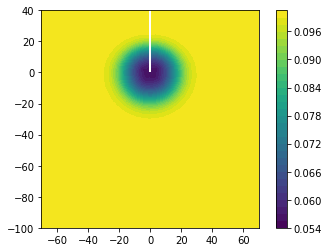

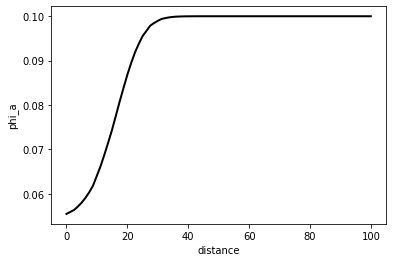

In [15]:
W = TensorFunctionSpace(mesh, "Lagrange", 2)

por_p = project(phi_a*Identity(2) , W)

# (1-phi)/phi_a *(P1*R*T* Finv.T)

M5 = plot(por_p[1,1])
plt.colorbar(M5)
plt.show()

P0 = por_p[1,1]

tol = 0.001  # avoid hitting points outside the domain
yy = np.linspace(0.0 + tol, 100.0 - tol, 81)
points = [(0 , -yy_ ) for yy_ in yy]  # 2D points
u_line = np.array([P0(point) for point in points])
plt.plot(yy, u_line, 'k', linewidth=2)
plt.ylabel('phi_a')
plt.xlabel('distance')
plt.show()

np.savetxt('y_phi_a.CSV',u_line)
np.savetxt('x.CSV',yy)

por_p1 = por_p[1,1]
p_project = project(por_p1, V.sub(1).collapse())

vtkfile = File('unsaturated/4.pvd')
vtkfile << p_project

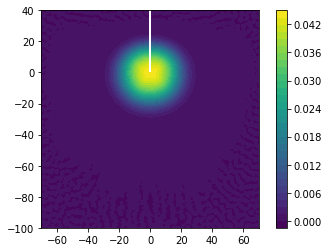

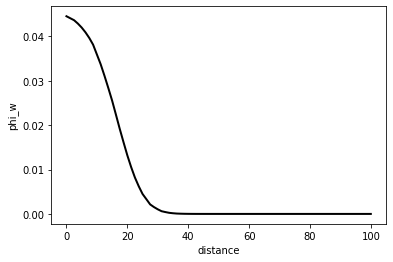

In [16]:
W = TensorFunctionSpace(mesh, "Lagrange", 2)

por_p = project(phi_w*Identity(2) , W)

# (1-phi)/phi_a *(P1*R*T* Finv.T)

M5 = plot(por_p[1,1])
plt.colorbar(M5)
plt.show()

P0 = por_p[1,1]

tol = 0.001  # avoid hitting points outside the domain
yy = np.linspace(0.0 + tol, 100.0 - tol, 81)
points = [(0 , -yy_ ) for yy_ in yy]  # 2D points
u_line = np.array([P0(point) for point in points])
plt.plot(yy, u_line, 'k', linewidth=2)
plt.ylabel('phi_w')
plt.xlabel('distance')
plt.show()

np.savetxt('y_phi_w.CSV',u_line)
# np.savetxt('xp.CSV',yy)

por_p1 = por_p[1,1]
p_project = project(por_p1, V.sub(1).collapse())

vtkfile = File('unsaturated/5.pvd')
vtkfile << p_project